# Web scraping solution

## Step 1: Install dependencies

In [1]:
!pip install pandas requests

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Step 2: Download HTML

In [1]:
import requests
import time

url = " https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
html_data = requests.get(url, time.sleep(10)).text

# If not information is extracted, then connect as anonymous
if "403 Forbidden" in html_data:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    html_data = request.text

html_data

'\r\n<!DOCTYPE html>\r\n<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\r\n<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->\r\n<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->\r\n<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->\r\n    <head>\r\n        <meta charset="utf-8">\r\n        <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\r\n\t\t<link rel="canonical" href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" />\r\n\t\t<title>Tesla Revenue 2010-2023 | TSLA | MacroTrends</title>\r\n\t\t<link rel="icon" type="image/x-icon" href="/assets/images/icons/FAVICON/macrotrends-favicon.ico">\r\n\t\t<meta name="description" content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2023. Revenue can be defined as the amount of money a company receives from its customers in exchange for the sales of goods or services.  Revenue is the top line item on an income statement

## Step 3: Transform the HTML

In [3]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(html_data,"html.parser")
soup


<!DOCTYPE html>

<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<link href="https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" rel="canonical"/>
<title>Tesla Revenue 2010-2023 | TSLA | MacroTrends</title>
<link href="/assets/images/icons/FAVICON/macrotrends-favicon.ico" rel="icon" type="image/x-icon"/>
<meta content="Tesla annual/quarterly revenue history and growth rate from 2010 to 2023. Revenue can be defined as the amount of money a company receives from its customers in exchange for the sales of goods or services.  Revenue is the top line item on an income statement from which all costs and expenses are subtracted to arrive at net income.    
				
				&

In [4]:
#Find all tables
tables = soup.find_all("table")
tables

[<table class="historical_data_table table">
 <thead>
 <tr>
 <th colspan="2" style="text-align:center">Tesla Annual Revenue<br/><span style="font-size:14px;">(Millions of US $)</span></th>
 </tr>
 </thead>
 <tbody>
 <tr>
 <td style="text-align:center">2022</td>
 <td style="text-align:center">$81,462</td>
 </tr>
 <tr>
 <td style="text-align:center">2021</td>
 <td style="text-align:center">$53,823</td>
 </tr>
 <tr>
 <td style="text-align:center">2020</td>
 <td style="text-align:center">$31,536</td>
 </tr>
 <tr>
 <td style="text-align:center">2019</td>
 <td style="text-align:center">$24,578</td>
 </tr>
 <tr>
 <td style="text-align:center">2018</td>
 <td style="text-align:center">$21,461</td>
 </tr>
 <tr>
 <td style="text-align:center">2017</td>
 <td style="text-align:center">$11,759</td>
 </tr>
 <tr>
 <td style="text-align:center">2016</td>
 <td style="text-align:center">$7,000</td>
 </tr>
 <tr>
 <td style="text-align:center">2015</td>
 <td style="text-align:center">$4,046</td>
 </tr>
 <t

In [5]:
import pandas as pd

for index, table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        break

# Create a DataFrame
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)

tesla_revenue.head()

,Date,Revenue
0,2023-06-30,24927
1,2023-03-31,23329
2,2022-12-31,24318
3,2022-09-30,21454
4,2022-06-30,16934


## Step 4: Process the DataFrame

In [6]:
tesla_revenue = tesla_revenue[tesla_revenue["Revenue"] != ""]
tesla_revenue.head()

,Date,Revenue
0,2023-06-30,24927
1,2023-03-31,23329
2,2022-12-31,24318
3,2022-09-30,21454
4,2022-06-30,16934


## Step 5: Store the data in sqlite

In [7]:
import sqlite3

connection = sqlite3.connect("Tesla.db")
connection

In [8]:
cursor = connection.cursor()
cursor.execute("""CREATE TABLE revenue (Date, Revenue)""")

In [9]:
tesla_tuples = list(tesla_revenue.to_records(index = False))
tesla_tuples[:5]

[('2023-06-30', '24927'),
 ('2023-03-31', '23329'),
 ('2022-12-31', '24318'),
 ('2022-09-30', '21454'),
 ('2022-06-30', '16934')]

In [10]:
cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla_tuples)
connection.commit()

In [11]:
# Check the data from the database
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

('2023-06-30', '24927')
('2023-03-31', '23329')
('2022-12-31', '24318')
('2022-09-30', '21454')
('2022-06-30', '16934')
('2022-03-31', '18756')
('2021-12-31', '17719')
('2021-09-30', '13757')
('2021-06-30', '11958')
('2021-03-31', '10389')
('2020-12-31', '10744')
('2020-09-30', '8771')
('2020-06-30', '6036')
('2020-03-31', '5985')
('2019-12-31', '7384')
('2019-09-30', '6303')
('2019-06-30', '6350')
('2019-03-31', '4541')
('2018-12-31', '7226')
('2018-09-30', '6824')
('2018-06-30', '4002')
('2018-03-31', '3409')
('2017-12-31', '3288')
('2017-09-30', '2985')
('2017-06-30', '2790')
('2017-03-31', '2696')
('2016-12-31', '2285')
('2016-09-30', '2298')
('2016-06-30', '1270')
('2016-03-31', '1147')
('2015-12-31', '1214')
('2015-09-30', '937')
('2015-06-30', '955')
('2015-03-31', '940')
('2014-12-31', '957')
('2014-09-30', '852')
('2014-06-30', '769')
('2014-03-31', '621')
('2013-12-31', '615')
('2013-09-30', '431')
('2013-06-30', '405')
('2013-03-31', '562')
('2012-12-31', '306')
('2012-09-30

## Step 6: Visualize the data

### Time serie visualization

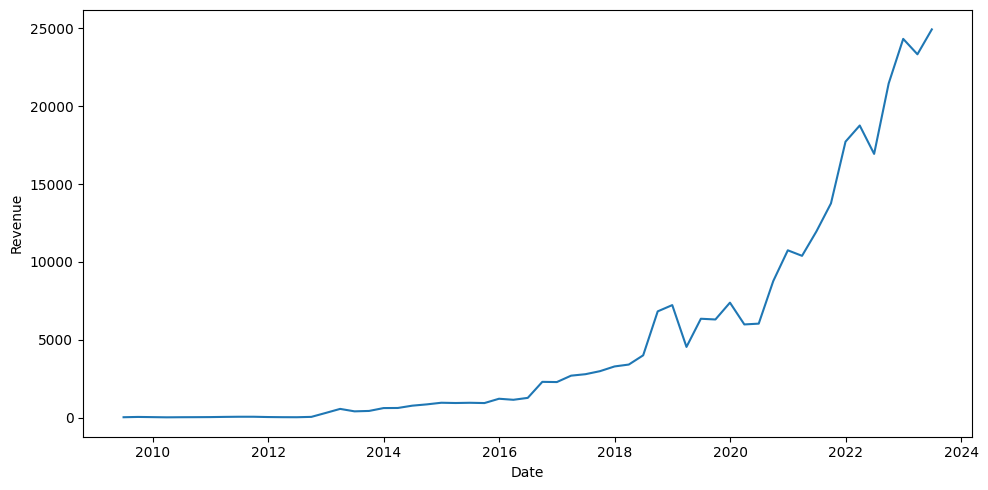

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

### Anual gross benefit

In [2]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year).sum().reset_index()

sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023], x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

NameError: name 'plt' is not defined

### Monthly gross benefit

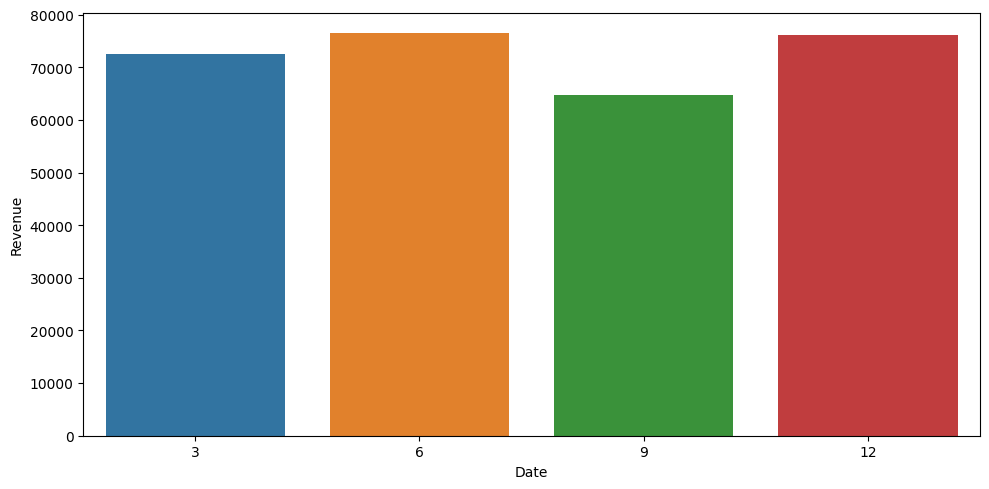

In [14]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["Date"].dt.month).sum().reset_index()

sns.barplot(data = tesla_revenue_monthly, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()